In [27]:
!pip install albumentations
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

^C


In [ ]:
!pip install segmentation-models-pytorch
!pip install torchsummary


In [ ]:
!pip install huggingface-hub==0.16.4


   ---------------------------------------- 0.0/268.8 kB ? eta -:--:--
   - -------------------------------------- 10.2/268.8 kB ? eta -:--:--
   ---------- ---------------------------- 71.7/268.8 kB 975.2 kB/s eta 0:00:01
   ------------------------- -------------- 174.1/268.8 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 268.8/268.8 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.6
    Uninstalling huggingface-hub-0.24.6:
      Successfully uninstalled huggingface-hub-0.24.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires huggingface-hub>=0.21.2, but you have huggingface-hub 0.16.4 which is incompatible.
segmentation-models-pytorch 0.3.4 requires huggingface-hub>=0.24.6, but you have huggingface-hub 0.16.4 which is incompatible.
transformers 4.44.2 requires huggingface-hub<1.0,>=0.23.2, but you have huggingface-hub 0.16.4 which is incompatible.


In [1]:
import segmentation_models_pytorch as smp
from torchsummary import summary


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

#print(os.getenv('PATH'))
print(torch.cuda.is_available())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True


c:\Users\Yang_PC\anaconda3\envs\py310cuda118\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


device(type='cuda')

In [4]:
from pathlib import Path

# For local file paths (Windows)
data_directory = Path(r'D:\ML_Seagrass\SourceData\Washington\Washington\train')

IMAGE_PATH = data_directory / "image"
MASK_PATH = data_directory / "index"

print("image_path:", IMAGE_PATH)



image_path: D:\ML_Seagrass\SourceData\Washington\Washington\train\image


In [5]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision not available.")

torch version: 2.1.1+cu118
torchvision version: 0.16.1+cu118


In [6]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should return the current GPU device
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU


True
0
NVIDIA GeForce RTX 3060


In [7]:
n_classes = 2 # classes of the mask

def create_dataframe():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id':name}, index= np.arange(0, len(name)))

df = create_dataframe()

df

,id
0,BH_WA_19_row10_col4
1,BH_WA_19_row10_col6
2,BH_WA_19_row1_col14
3,BH_WA_19_row2_col15
4,BH_WA_19_row3_col13
...,...
1196,NC_WA_22_row9_col10
1197,NC_WA_22_row9_col5
1198,NC_WA_22_row9_col6
1199,NC_WA_22_row9_col7


In [8]:
# X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
# X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

# Independent folders for train, validation, and test images
train_folder = r'D:\ML_Seagrass\SourceData\Washington\Washington\train'
val_folder = r'D:\ML_Seagrass\SourceData\Washington\Washington\valid'
test_folder = r'D:\ML_Seagrass\SourceData\Washington\Washington\test'

# Load all image paths from respective folders
X_train = [os.path.join(train_folder, img) for img in os.listdir(train_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]
X_val = [os.path.join(val_folder, img) for img in os.listdir(val_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]
X_test = [os.path.join(test_folder, img) for img in os.listdir(test_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]





In [12]:
import os
import pandas as pd

# Define paths to the train, valid, and test image and mask folders
# Example usage
main_folder = r'D:\ML_Seagrass\SourceData\Washington\Washington'

train_image_folder = os.path.join(main_folder, 'train', 'image')
train_mask_folder = os.path.join(main_folder, 'train', 'index')
val_image_folder = os.path.join(main_folder, 'valid', 'image')
val_mask_folder = os.path.join(main_folder, 'valid', 'index')
test_image_folder = os.path.join(main_folder, 'test', 'image')
test_mask_folder = os.path.join(main_folder, 'test', 'index')
    
# Function to create dataframes from the given folder structure
def create_dataframes_from_main_folder(main_folder):
    

    # Helper function to create a dataframe from image and mask folders
    def create_dataframe_from_folders(image_folder, mask_folder):
        image_names = [img.split('.')[0] for img in os.listdir(image_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]
        mask_names = [mask.split('.')[0] for mask in os.listdir(mask_folder) if mask.endswith(('.jpg', '.png', '.jpeg'))]

        # Ensure that the image and mask file names match
        assert set(image_names) == set(mask_names), "Image and mask file names do not match!"

        return pd.DataFrame({'id': image_names})

    # Create dataframes for train, valid, and test sets
    df_train = create_dataframe_from_folders(train_image_folder, train_mask_folder)
    df_val = create_dataframe_from_folders(val_image_folder, val_mask_folder)
    df_test = create_dataframe_from_folders(test_image_folder, test_mask_folder)

    # Return dataframes
    return df_train, df_val, df_test

  # Replace with the path to your main folder
df_train, df_val, df_test = create_dataframes_from_main_folder(main_folder)

# Assign X_train, X_val, and X_test
X_train = df_train['id'].values
X_val = df_val['id'].values
X_test = df_test['id'].values


Image Path: D:\ML_Seagrass\SourceData\Washington\Washington\valid\image\BH_WA_19_row10_col5.png
Mask Path: D:\ML_Seagrass\SourceData\Washington\Washington\valid\index\BH_WA_19_row10_col5.png


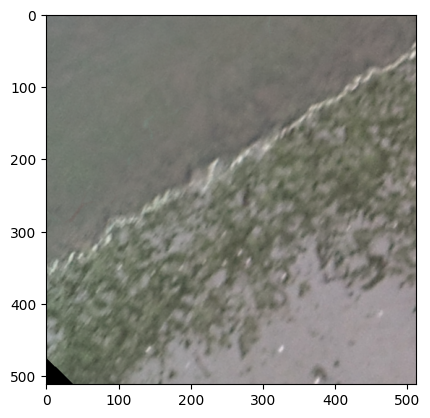

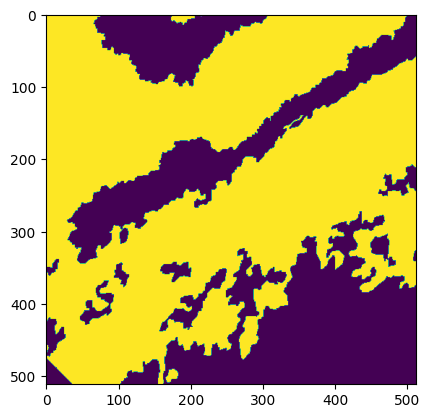

(512, 512, 3)
(512, 512)


In [13]:
for idx in X_val:
    img_path = os.path.join(val_image_folder, idx + '.png')
    mask_path = os.path.join(val_mask_folder, idx + '.png')

    
    # Print out the file paths for debugging
    print("Image Path:", img_path)
    print("Mask Path:", mask_path)
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    plt.imshow(img)
    plt.show()
    plt.imshow(mask)
    plt.show()
    print(np.asarray(img).shape)
    print(np.asarray(mask).shape)
    break

In [14]:
class Drone_data(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_path = self.img_path / f'{self.X[idx]}.png'
        mask_path = self.mask_path / f'{self.X[idx]}.png'
        
        # Read and convert the image to RGB
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Open and convert the mask to grayscale
        mask = Image.open(mask_path)
        mask = mask.convert("L")
        mask = np.array(mask)

        # Map mask values: 255 -> 1
        mask = np.where(mask == 255, 1, 0).astype(np.uint8)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']

        # Convert image to tensor and normalize
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        
        # Convert mask to a tensor
        mask = torch.from_numpy(mask).long()

        if self.patch:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        # Implementation of tile extraction if needed
        pass

In [33]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = Drone_data(train_image_folder, train_mask_folder, X_train, mean, std, t_train, patch=False)
val_set = Drone_data(val_image_folder, val_mask_folder, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [18]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [16]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [17]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [20]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            #output = torch.argmax(output, dim=1)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    
    total_time_minutes = (time.time() - fit_time) / 60

    # Print the total time
    print('Total time: {:.2f} m'.format(total_time_minutes))

    #print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
torch.cuda.empty_cache()

In [21]:
import subprocess

def check_gpu_memory():
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

check_gpu_memory()

Thu Oct 17 19:33:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 37%   47C    P8             11W /  170W |     702MiB /  12288MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
import os
import torch

# Enable CUDA_LAUNCH_BLOCKING
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Your previous setup code
max_lr = 1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

# Ensure model is on the correct device
model.to(device)




Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [ ]:
# Run fit function
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

In [ ]:
max_lr = 1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.394 
Epoch:1/20.. Train Loss: 0.444.. Val Loss: 0.394.. Train mIoU:0.635.. Val mIoU: 0.673.. Train Acc:0.781.. Val Acc:0.814.. Time: 2.25m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.394 >> 0.379 
Epoch:2/20.. Train Loss: 0.441.. Val Loss: 0.379.. Train mIoU:0.639.. Val mIoU: 0.674.. Train Acc:0.783.. Val Acc:0.821.. Time: 2.21m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/20.. Train Loss: 0.465.. Val Loss: 0.402.. Train mIoU:0.627.. Val mIoU: 0.671.. Train Acc:0.775.. Val Acc:0.810.. Time: 2.26m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.402 >> 0.386 
Epoch:4/20.. Train Loss: 0.453.. Val Loss: 0.386.. Train mIoU:0.636.. Val mIoU: 0.678.. Train Acc:0.779.. Val Acc:0.817.. Time: 2.24m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:5/20.. Train Loss: 0.470.. Val Loss: 0.397.. Train mIoU:0.615.. Val mIoU: 0.673.. Train Acc:0.764.. Val Acc:0.817.. Time: 2.24m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.397 >> 0.386 
saving model...
Epoch:6/20.. Train Loss: 0.456.. Val Loss: 0.386.. Train mIoU:0.632.. Val mIoU: 0.676.. Train Acc:0.776.. Val Acc:0.819.. Time: 2.27m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:7/20.. Train Loss: 0.459.. Val Loss: 0.477.. Train mIoU:0.629.. Val mIoU: 0.656.. Train Acc:0.774.. Val Acc:0.806.. Time: 2.26m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.477 >> 0.389 
Epoch:8/20.. Train Loss: 0.457.. Val Loss: 0.389.. Train mIoU:0.633.. Val mIoU: 0.669.. Train Acc:0.779.. Val Acc:0.822.. Time: 2.25m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:9/20.. Train Loss: 0.458.. Val Loss: 0.451.. Train mIoU:0.624.. Val mIoU: 0.642.. Train Acc:0.774.. Val Acc:0.798.. Time: 2.27m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.451 >> 0.400 
Epoch:10/20.. Train Loss: 0.459.. Val Loss: 0.400.. Train mIoU:0.629.. Val mIoU: 0.673.. Train Acc:0.777.. Val Acc:0.817.. Time: 2.24m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.400 >> 0.371 
Epoch:11/20.. Train Loss: 0.454.. Val Loss: 0.371.. Train mIoU:0.635.. Val mIoU: 0.692.. Train Acc:0.779.. Val Acc:0.832.. Time: 2.20m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:12/20.. Train Loss: 0.431.. Val Loss: 0.375.. Train mIoU:0.654.. Val mIoU: 0.707.. Train Acc:0.794.. Val Acc:0.833.. Time: 2.25m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:13/20.. Train Loss: 0.437.. Val Loss: 0.385.. Train mIoU:0.646.. Val mIoU: 0.702.. Train Acc:0.790.. Val Acc:0.831.. Time: 2.22m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Decreasing.. 0.385 >> 0.377 
Epoch:14/20.. Train Loss: 0.430.. Val Loss: 0.377.. Train mIoU:0.647.. Val mIoU: 0.688.. Train Acc:0.789.. Val Acc:0.832.. Time: 2.25m


  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 33.61 m


In [ ]:
torch.save(model, 'Unet-mobilenet2-batchsize4-Alaska_lr-4.pt')

In [24]:
model_path = r'D:\ML_Seagrass\models\checkpoints\Unet-mobilenet2-batchsize8-WA_NON_ZERO_lr-4.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path)
model.to(device)




Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [25]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [26]:
plot_loss(history)
plot_score(history)
plot_acc(history)

NameError: name 'history' is not defined

In [ ]:
import torchvision.transforms as transforms

def to_tensor(image):
    return transforms.ToTensor()(image)

In [28]:
class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_file_name = f'{self.X[idx]}.png'
        img_path = self.img_path / img_file_name
        mask_path = self.mask_path / img_file_name
        
        # Read and convert the image to RGB using OpenCV
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Read the mask in grayscale directly using OpenCV
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            # Convert image and mask to NumPy arrays for transformation
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        # Convert the image to PIL Image (consistent with DroneTestDataset1)
        img = Image.fromarray(img)

        # Convert mask to a PyTorch tensor
        mask = torch.from_numpy(mask).long()

        # Return the image, mask, and file name
        return img, mask, img_file_name

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(test_image_folder, test_mask_folder, X_test, transform=t_test)

In [67]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np


# Updated function to perform inference and save the predicted mask with resizing
def predict_image_mask_miou(model, image, mask, save_file, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()  # Set the model to evaluation mode
    
    # Store original image dimensions before transforming
    original_height, original_width = 512, 512  # PIL Image size: (width, height)
    
    # Apply transformation to the image (e.g., normalization)
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image_tensor = t(image)  # Keep 'image' unchanged for later use
    
    # Move image and mask to the appropriate device
    image_tensor = image_tensor.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():  # Disable gradient calculation for inference
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension for the model
        mask = mask.unsqueeze(0)    # Add batch dimension

        output = model(image_tensor)  # Run model inference
        score = mIoU(output, mask)  # Compute mIoU score
        
        # Get the predicted mask by taking the argmax of the model's output
        pred_mask = torch.argmax(output, dim=1)
        pred_mask = pred_mask.cpu().squeeze(0)  # Move to CPU and remove batch dimension

    # Resize the predicted mask to match the original image size
    pred_mask_resized = cv2.resize(pred_mask.numpy(), (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    
    # Save the resized predicted mask as a grayscale image
    plt.imsave(save_file, pred_mask_resized, cmap='gray')  # Save mask as a grayscale image
    
    return pred_mask_resized, score


import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def save_predicted_mask_overlay(pred_mask, img_file_name, image_folder, save_file, alpha=0.3):
    """
    Overlays the predicted mask on the original image read from a specified folder, and saves the result.
    
    Parameters:
    - pred_mask: The predicted mask (PyTorch tensor or NumPy array with values 0 and 1).
    - img_file_name: The name of the image file (e.g., 'image_001.png').
    - image_folder: The path to the folder where the original image is located.
    - save_file: The path to save the overlaid image.
    - alpha: The transparency factor for the overlay (default is 0.3 for higher transparency).
    """
    # Build the full image path
    img_path = os.path.join(image_folder, img_file_name)

    # Read the original image from the specified folder
    original_image = Image.open(img_path).convert('RGB')  # Use PIL to read the image
    original_image = np.array(original_image)  # Convert to NumPy array

    # Convert the predicted mask to a NumPy array if it's a PyTorch tensor
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()

    # Ensure the predicted mask has 2D shape (height, width)
    if pred_mask.ndim != 2:
        raise ValueError(f"Expected 2D mask, but got shape {pred_mask.shape}")

    # Resize the predicted mask to match the original image size (assuming original image size is 512x512)
    original_height, original_width = original_image.shape[:2]
    pred_mask_resized = cv2.resize(pred_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    # Ensure the image is in the correct format (height, width, 3)
    if original_image.ndim != 3 or original_image.shape[2] != 3:
        raise ValueError(f"Expected 3D RGB image, but got shape {original_image.shape}")

    # Create a copy of the original image to modify
    overlay = original_image.copy()

    # Broadcast the mask across the 3 RGB channels (set the mask area to light blue)
    light_blue_color = [173, 216, 230]  # Light blue RGB
    light_blue_mask = np.zeros_like(overlay)
    light_blue_mask[pred_mask_resized == 1] = light_blue_color  # Light blue for class 1 (object)

    # Blend the original image and the light blue mask, keeping the original image intensity intact
    blended_image = cv2.addWeighted(light_blue_mask, alpha, original_image, 1, 0)

    # Save the blended image
    plt.imsave(save_file, blended_image)
    print(f"Saved overlay image: {save_file}")


In [68]:
import os
from tqdm import tqdm

# Define the save path for the predicted masks and the folder for original images
original_image_folder = r'D:\ML_Seagrass\SourceData\Washington\Washington\test\image'  # Folder with original images
save_path = r'D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay'
Pred_mask_path = r'D:\ML_Seagrass\SourceData\Washington\Washington\test\predicted'

# Ensure the directories exist
os.makedirs(save_path, exist_ok=True)
os.makedirs(Pred_mask_path, exist_ok=True)

# Loop through all images in the test set
for idx in tqdm(range(len(test_set))):
    image, mask, img_file_name = test_set[idx]  # Get mask and filename from test_set
    
    # Define the save path for the current predicted mask
    save_overlay_file = os.path.join(save_path, f'{img_file_name}')  # Save with filename
    save_predicted_file = os.path.join(Pred_mask_path, f'{img_file_name}')
     
    # Run inference to get the predicted mask
    pred_mask, score = predict_image_mask_miou(model, image, mask, save_predicted_file)
    
    # Save the overlay of the predicted mask on the original image read from `original_image_folder`
    save_predicted_mask_overlay(pred_mask, img_file_name, original_image_folder, save_overlay_file)
    
    # Optionally, log the progress or save additional data
    print(f"Saved predicted mask for {img_file_name} with mIoU score: {score:.3f}")


  1%|          | 1/172 [00:00<01:39,  1.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_19_row4_col12.png
Saved predicted mask for BH_WA_19_row4_col12.png with mIoU score: 0.628


  1%|          | 2/172 [00:00<01:13,  2.32it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_19_row6_col11.png
Saved predicted mask for BH_WA_19_row6_col11.png with mIoU score: 0.565


  2%|▏         | 3/172 [00:01<01:04,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row12_col10.png
Saved predicted mask for BH_WA_20_row12_col10.png with mIoU score: 0.969


  2%|▏         | 4/172 [00:01<01:02,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row12_col6.png
Saved predicted mask for BH_WA_20_row12_col6.png with mIoU score: 0.027


  3%|▎         | 5/172 [00:01<01:02,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row2_col17.png
Saved predicted mask for BH_WA_20_row2_col17.png with mIoU score: 0.932


  3%|▎         | 6/172 [00:02<01:00,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row3_col16.png
Saved predicted mask for BH_WA_20_row3_col16.png with mIoU score: 0.944


  4%|▍         | 7/172 [00:02<00:59,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row8_col10.png
Saved predicted mask for BH_WA_20_row8_col10.png with mIoU score: 0.744


  5%|▍         | 8/172 [00:03<01:00,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row9_col14.png
Saved predicted mask for BH_WA_20_row9_col14.png with mIoU score: 0.880


  5%|▌         | 9/172 [00:03<01:00,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row9_col8.png
Saved predicted mask for BH_WA_20_row9_col8.png with mIoU score: 0.589


  6%|▌         | 10/172 [00:03<00:58,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row12_col8.png
Saved predicted mask for BH_WA_21_row12_col8.png with mIoU score: 0.917


  6%|▋         | 11/172 [00:04<01:00,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row3_col15.png
Saved predicted mask for BH_WA_21_row3_col15.png with mIoU score: 0.651


  7%|▋         | 12/172 [00:04<01:07,  2.38it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row4_col13.png
Saved predicted mask for BH_WA_21_row4_col13.png with mIoU score: 0.936


  8%|▊         | 13/172 [00:05<01:07,  2.35it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row5_col14.png
Saved predicted mask for BH_WA_21_row5_col14.png with mIoU score: 0.143


  8%|▊         | 14/172 [00:05<01:07,  2.34it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row6_col12.png
Saved predicted mask for BH_WA_21_row6_col12.png with mIoU score: 0.534


  9%|▊         | 15/172 [00:05<01:05,  2.41it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row8_col8.png
Saved predicted mask for BH_WA_21_row8_col8.png with mIoU score: 0.816


  9%|▉         | 16/172 [00:06<01:03,  2.45it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row9_col12.png
Saved predicted mask for BH_WA_21_row9_col12.png with mIoU score: 0.890


 10%|▉         | 17/172 [00:06<01:03,  2.45it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row12_col8.png
Saved predicted mask for BH_WA_22_row12_col8.png with mIoU score: 0.288


 10%|█         | 18/172 [00:07<01:02,  2.47it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row6_col17.png
Saved predicted mask for BH_WA_22_row6_col17.png with mIoU score: 0.062


 11%|█         | 19/172 [00:07<00:56,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row7_col13.png
Saved predicted mask for BH_WA_22_row7_col13.png with mIoU score: 0.854


 12%|█▏        | 20/172 [00:07<00:59,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row7_col15.png
Saved predicted mask for BH_WA_22_row7_col15.png with mIoU score: 0.496


 12%|█▏        | 21/172 [00:08<00:59,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row8_col13.png
Saved predicted mask for BH_WA_22_row8_col13.png with mIoU score: 0.371


 13%|█▎        | 22/172 [00:08<00:51,  2.88it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row9_col9.png
Saved predicted mask for BH_WA_22_row9_col9.png with mIoU score: 0.862


 13%|█▎        | 23/172 [00:08<00:53,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row10_col11.png
Saved predicted mask for FB_WA_19_row10_col11.png with mIoU score: 0.154


 14%|█▍        | 24/172 [00:09<00:54,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row10_col8.png
Saved predicted mask for FB_WA_19_row10_col8.png with mIoU score: 0.279


 15%|█▍        | 25/172 [00:09<00:54,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row11_col11.png
Saved predicted mask for FB_WA_19_row11_col11.png with mIoU score: 0.207


 15%|█▌        | 26/172 [00:10<00:54,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row11_col3.png
Saved predicted mask for FB_WA_19_row11_col3.png with mIoU score: 0.584


 16%|█▋        | 28/172 [00:10<00:46,  3.10it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row13_col3.png
Saved predicted mask for FB_WA_19_row13_col3.png with mIoU score: 0.337
Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row2_col6.png
Saved predicted mask for FB_WA_19_row2_col6.png with mIoU score: 0.368


 17%|█▋        | 29/172 [00:10<00:43,  3.30it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row2_col8.png
Saved predicted mask for FB_WA_19_row2_col8.png with mIoU score: 0.539


 17%|█▋        | 30/172 [00:11<00:40,  3.50it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row3_col14.png
Saved predicted mask for FB_WA_19_row3_col14.png with mIoU score: 0.891


 18%|█▊        | 31/172 [00:11<00:38,  3.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row4_col3.png
Saved predicted mask for FB_WA_19_row4_col3.png with mIoU score: 0.698


 19%|█▊        | 32/172 [00:11<00:39,  3.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row4_col8.png
Saved predicted mask for FB_WA_19_row4_col8.png with mIoU score: 0.448


 19%|█▉        | 33/172 [00:12<00:42,  3.28it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row5_col15.png
Saved predicted mask for FB_WA_19_row5_col15.png with mIoU score: 0.259


 20%|█▉        | 34/172 [00:12<00:42,  3.22it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row5_col16.png
Saved predicted mask for FB_WA_19_row5_col16.png with mIoU score: 0.513


 20%|██        | 35/172 [00:12<00:44,  3.07it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row5_col21.png
Saved predicted mask for FB_WA_19_row5_col21.png with mIoU score: 0.907


 21%|██        | 36/172 [00:13<00:45,  3.00it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row5_col22.png
Saved predicted mask for FB_WA_19_row5_col22.png with mIoU score: 0.937


 22%|██▏       | 37/172 [00:13<00:45,  2.98it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row6_col19.png
Saved predicted mask for FB_WA_19_row6_col19.png with mIoU score: 0.251


 22%|██▏       | 38/172 [00:13<00:45,  2.92it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row8_col18.png
Saved predicted mask for FB_WA_19_row8_col18.png with mIoU score: 0.621


 23%|██▎       | 39/172 [00:14<00:47,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row9_col10.png
Saved predicted mask for FB_WA_19_row9_col10.png with mIoU score: 0.167


 23%|██▎       | 40/172 [00:14<00:47,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row10_col6.png
Saved predicted mask for FB_WA_20_row10_col6.png with mIoU score: 0.749


 24%|██▍       | 41/172 [00:14<00:49,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row11_col15.png
Saved predicted mask for FB_WA_20_row11_col15.png with mIoU score: 0.935


 24%|██▍       | 42/172 [00:15<00:48,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row11_col7.png
Saved predicted mask for FB_WA_20_row11_col7.png with mIoU score: 0.896


 25%|██▌       | 43/172 [00:15<00:45,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row1_col14.png
Saved predicted mask for FB_WA_20_row1_col14.png with mIoU score: 0.905


 26%|██▌       | 44/172 [00:15<00:45,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row3_col16.png
Saved predicted mask for FB_WA_20_row3_col16.png with mIoU score: 0.977


 26%|██▌       | 45/172 [00:16<00:44,  2.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row5_col8.png
Saved predicted mask for FB_WA_20_row5_col8.png with mIoU score: 0.852


 27%|██▋       | 46/172 [00:16<00:44,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row6_col10.png
Saved predicted mask for FB_WA_20_row6_col10.png with mIoU score: 0.837


 27%|██▋       | 47/172 [00:17<00:46,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row6_col9.png
Saved predicted mask for FB_WA_20_row6_col9.png with mIoU score: 0.561


 28%|██▊       | 48/172 [00:17<00:47,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row7_col7.png
Saved predicted mask for FB_WA_20_row7_col7.png with mIoU score: 0.680


 28%|██▊       | 49/172 [00:17<00:47,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row8_col12.png
Saved predicted mask for FB_WA_20_row8_col12.png with mIoU score: 0.815


 29%|██▉       | 50/172 [00:18<00:46,  2.62it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row8_col9.png
Saved predicted mask for FB_WA_20_row8_col9.png with mIoU score: 0.747


 30%|██▉       | 51/172 [00:18<00:44,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_21_row7_col11.png
Saved predicted mask for FB_WA_21_row7_col11.png with mIoU score: 0.752


 30%|███       | 52/172 [00:18<00:45,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_21_row7_col5.png
Saved predicted mask for FB_WA_21_row7_col5.png with mIoU score: 0.935


 31%|███       | 53/172 [00:19<00:45,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_21_row8_col14.png
Saved predicted mask for FB_WA_21_row8_col14.png with mIoU score: 0.401


 31%|███▏      | 54/172 [00:19<00:44,  2.65it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row6_col8.png
Saved predicted mask for FB_WA_22_row6_col8.png with mIoU score: 0.422


 32%|███▏      | 55/172 [00:20<00:44,  2.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row7_col11.png
Saved predicted mask for FB_WA_22_row7_col11.png with mIoU score: 0.679


 33%|███▎      | 56/172 [00:20<00:45,  2.55it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row7_col12.png
Saved predicted mask for FB_WA_22_row7_col12.png with mIoU score: 0.628


 33%|███▎      | 57/172 [00:20<00:46,  2.47it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row7_col8.png
Saved predicted mask for FB_WA_22_row7_col8.png with mIoU score: 0.363


 34%|███▎      | 58/172 [00:21<00:46,  2.47it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row8_col10.png
Saved predicted mask for FB_WA_22_row8_col10.png with mIoU score: 0.928


 34%|███▍      | 59/172 [00:21<00:47,  2.40it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row8_col14.png
Saved predicted mask for FB_WA_22_row8_col14.png with mIoU score: 0.853


 35%|███▍      | 60/172 [00:22<00:42,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_19_row3_col10.png
Saved predicted mask for IC_WA_19_row3_col10.png with mIoU score: 0.977


 35%|███▌      | 61/172 [00:22<00:42,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_19_row4_col9.png
Saved predicted mask for IC_WA_19_row4_col9.png with mIoU score: 0.102


 36%|███▌      | 62/172 [00:22<00:41,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row10_col7.png
Saved predicted mask for IC_WA_20_row10_col7.png with mIoU score: 0.712


 37%|███▋      | 63/172 [00:23<00:41,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row11_col22.png
Saved predicted mask for IC_WA_20_row11_col22.png with mIoU score: 0.327


 37%|███▋      | 64/172 [00:23<00:39,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row15_col15.png
Saved predicted mask for IC_WA_20_row15_col15.png with mIoU score: 0.796


 38%|███▊      | 65/172 [00:23<00:35,  2.99it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row15_col17.png
Saved predicted mask for IC_WA_20_row15_col17.png with mIoU score: 0.866


 38%|███▊      | 66/172 [00:24<00:36,  2.91it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row3_col11.png
Saved predicted mask for IC_WA_20_row3_col11.png with mIoU score: 0.901


 39%|███▉      | 67/172 [00:24<00:36,  2.89it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row6_col17.png
Saved predicted mask for IC_WA_20_row6_col17.png with mIoU score: 0.846


 40%|███▉      | 68/172 [00:24<00:33,  3.07it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row6_col23.png
Saved predicted mask for IC_WA_20_row6_col23.png with mIoU score: 0.996


 40%|████      | 69/172 [00:25<00:38,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row7_col13.png
Saved predicted mask for IC_WA_20_row7_col13.png with mIoU score: 0.899


 41%|████      | 70/172 [00:25<00:38,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row8_col23.png
Saved predicted mask for IC_WA_20_row8_col23.png with mIoU score: 0.519


 41%|████▏     | 71/172 [00:26<00:40,  2.51it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row9_col18.png
Saved predicted mask for IC_WA_20_row9_col18.png with mIoU score: 0.325


 42%|████▏     | 72/172 [00:26<00:39,  2.51it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row9_col23.png
Saved predicted mask for IC_WA_20_row9_col23.png with mIoU score: 0.051


 42%|████▏     | 73/172 [00:26<00:35,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row9_col24.png
Saved predicted mask for IC_WA_20_row9_col24.png with mIoU score: 0.968


 43%|████▎     | 74/172 [00:27<00:37,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row10_col10.png
Saved predicted mask for IC_WA_21_row10_col10.png with mIoU score: 0.001


 44%|████▎     | 75/172 [00:27<00:36,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row10_col5.png
Saved predicted mask for IC_WA_21_row10_col5.png with mIoU score: 0.832


 44%|████▍     | 76/172 [00:28<00:37,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row12_col11.png
Saved predicted mask for IC_WA_21_row12_col11.png with mIoU score: 0.094


 45%|████▍     | 77/172 [00:28<00:37,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row12_col13.png
Saved predicted mask for IC_WA_21_row12_col13.png with mIoU score: 0.426


 45%|████▌     | 78/172 [00:28<00:37,  2.52it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row12_col14.png
Saved predicted mask for IC_WA_21_row12_col14.png with mIoU score: 0.550


 46%|████▌     | 79/172 [00:29<00:36,  2.51it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row12_col17.png
Saved predicted mask for IC_WA_21_row12_col17.png with mIoU score: 0.868


 47%|████▋     | 80/172 [00:29<00:34,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row13_col12.png
Saved predicted mask for IC_WA_21_row13_col12.png with mIoU score: 0.391


 47%|████▋     | 81/172 [00:29<00:33,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row15_col9.png
Saved predicted mask for IC_WA_21_row15_col9.png with mIoU score: 0.917


 48%|████▊     | 82/172 [00:30<00:32,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row6_col22.png
Saved predicted mask for IC_WA_21_row6_col22.png with mIoU score: 0.363


 49%|████▉     | 84/172 [00:30<00:26,  3.26it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row7_col14.png
Saved predicted mask for IC_WA_21_row7_col14.png with mIoU score: 0.892
Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_22_row10_col9.png
Saved predicted mask for IC_WA_22_row10_col9.png with mIoU score: 0.937


 49%|████▉     | 85/172 [00:31<00:28,  3.02it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_22_row5_col9.png
Saved predicted mask for IC_WA_22_row5_col9.png with mIoU score: 0.785


 50%|█████     | 86/172 [00:31<00:32,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_22_row6_col16.png
Saved predicted mask for IC_WA_22_row6_col16.png with mIoU score: 0.901


 51%|█████     | 87/172 [00:32<00:37,  2.24it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_22_row8_col11.png
Saved predicted mask for IC_WA_22_row8_col11.png with mIoU score: 0.724


 51%|█████     | 88/172 [00:32<00:36,  2.30it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row12_col14.png
Saved predicted mask for JF_WA_19_row12_col14.png with mIoU score: 0.036


 52%|█████▏    | 89/172 [00:33<00:35,  2.37it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row13_col12.png
Saved predicted mask for JF_WA_19_row13_col12.png with mIoU score: 0.534


 53%|█████▎    | 91/172 [00:33<00:28,  2.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row14_col14.png
Saved predicted mask for JF_WA_19_row14_col14.png with mIoU score: 0.893
Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row14_col8.png
Saved predicted mask for JF_WA_19_row14_col8.png with mIoU score: 0.993


 53%|█████▎    | 92/172 [00:34<00:26,  2.96it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row15_col9.png
Saved predicted mask for JF_WA_19_row15_col9.png with mIoU score: 0.994


 54%|█████▍    | 93/172 [00:34<00:26,  2.97it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row2_col9.png
Saved predicted mask for JF_WA_19_row2_col9.png with mIoU score: 0.915


 55%|█████▍    | 94/172 [00:34<00:28,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row7_col9.png
Saved predicted mask for JF_WA_19_row7_col9.png with mIoU score: 0.037


 55%|█████▌    | 95/172 [00:35<00:31,  2.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row8_col6.png
Saved predicted mask for JF_WA_19_row8_col6.png with mIoU score: 0.208


 56%|█████▌    | 96/172 [00:35<00:33,  2.30it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row9_col18.png
Saved predicted mask for JF_WA_19_row9_col18.png with mIoU score: 0.472


 56%|█████▋    | 97/172 [00:36<00:31,  2.38it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row10_col10.png
Saved predicted mask for JF_WA_20_row10_col10.png with mIoU score: 0.020


 57%|█████▋    | 98/172 [00:36<00:29,  2.47it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row13_col20.png
Saved predicted mask for JF_WA_20_row13_col20.png with mIoU score: 0.737


 58%|█████▊    | 99/172 [00:36<00:28,  2.54it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row14_col13.png
Saved predicted mask for JF_WA_20_row14_col13.png with mIoU score: 0.557


 58%|█████▊    | 100/172 [00:37<00:28,  2.51it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row14_col19.png
Saved predicted mask for JF_WA_20_row14_col19.png with mIoU score: 0.588


 59%|█████▊    | 101/172 [00:37<00:33,  2.15it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row14_col24.png
Saved predicted mask for JF_WA_20_row14_col24.png with mIoU score: 0.708


 59%|█████▉    | 102/172 [00:38<00:31,  2.24it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row15_col24.png
Saved predicted mask for JF_WA_20_row15_col24.png with mIoU score: 0.869


 60%|█████▉    | 103/172 [00:38<00:30,  2.26it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row17_col19.png
Saved predicted mask for JF_WA_20_row17_col19.png with mIoU score: 0.441


 60%|██████    | 104/172 [00:39<00:31,  2.18it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row17_col22.png
Saved predicted mask for JF_WA_20_row17_col22.png with mIoU score: 0.039


 61%|██████    | 105/172 [00:39<00:30,  2.22it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row19_col19.png
Saved predicted mask for JF_WA_20_row19_col19.png with mIoU score: 0.533


 62%|██████▏   | 106/172 [00:40<00:30,  2.18it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row4_col7.png
Saved predicted mask for JF_WA_20_row4_col7.png with mIoU score: 0.706


 62%|██████▏   | 107/172 [00:40<00:28,  2.29it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row6_col4.png
Saved predicted mask for JF_WA_20_row6_col4.png with mIoU score: 0.501


 63%|██████▎   | 108/172 [00:40<00:26,  2.40it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row8_col16.png
Saved predicted mask for JF_WA_20_row8_col16.png with mIoU score: 0.929


 63%|██████▎   | 109/172 [00:41<00:26,  2.35it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row9_col8.png
Saved predicted mask for JF_WA_20_row9_col8.png with mIoU score: 0.377


 64%|██████▍   | 110/172 [00:41<00:26,  2.36it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row10_col10.png
Saved predicted mask for JF_WA_21_row10_col10.png with mIoU score: 0.850


 65%|██████▍   | 111/172 [00:42<00:24,  2.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row10_col5.png
Saved predicted mask for JF_WA_21_row10_col5.png with mIoU score: 0.839


 65%|██████▌   | 112/172 [00:42<00:24,  2.45it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row10_col8.png
Saved predicted mask for JF_WA_21_row10_col8.png with mIoU score: 0.682


 66%|██████▌   | 113/172 [00:42<00:24,  2.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row11_col19.png
Saved predicted mask for JF_WA_21_row11_col19.png with mIoU score: 0.346


 66%|██████▋   | 114/172 [00:43<00:23,  2.45it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row11_col22.png
Saved predicted mask for JF_WA_21_row11_col22.png with mIoU score: 0.506


 67%|██████▋   | 115/172 [00:43<00:22,  2.49it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row12_col14.png
Saved predicted mask for JF_WA_21_row12_col14.png with mIoU score: 0.931


 67%|██████▋   | 116/172 [00:44<00:22,  2.47it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row12_col18.png
Saved predicted mask for JF_WA_21_row12_col18.png with mIoU score: 0.594


 68%|██████▊   | 117/172 [00:44<00:21,  2.50it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row13_col12.png
Saved predicted mask for JF_WA_21_row13_col12.png with mIoU score: 0.605


 69%|██████▊   | 118/172 [00:44<00:21,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row14_col19.png
Saved predicted mask for JF_WA_21_row14_col19.png with mIoU score: 0.408


 69%|██████▉   | 119/172 [00:45<00:21,  2.50it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row15_col22.png
Saved predicted mask for JF_WA_21_row15_col22.png with mIoU score: 0.229


 70%|██████▉   | 120/172 [00:45<00:20,  2.50it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row15_col24.png
Saved predicted mask for JF_WA_21_row15_col24.png with mIoU score: 0.558


 70%|███████   | 121/172 [00:46<00:20,  2.54it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row16_col20.png
Saved predicted mask for JF_WA_21_row16_col20.png with mIoU score: 0.347


 71%|███████   | 122/172 [00:46<00:19,  2.58it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row16_col21.png
Saved predicted mask for JF_WA_21_row16_col21.png with mIoU score: 0.167


 72%|███████▏  | 123/172 [00:46<00:18,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row17_col15.png
Saved predicted mask for JF_WA_21_row17_col15.png with mIoU score: 0.910


 72%|███████▏  | 124/172 [00:47<00:17,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row17_col16.png
Saved predicted mask for JF_WA_21_row17_col16.png with mIoU score: 0.855


 73%|███████▎  | 125/172 [00:47<00:17,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row17_col22.png
Saved predicted mask for JF_WA_21_row17_col22.png with mIoU score: 0.579


 73%|███████▎  | 126/172 [00:47<00:16,  2.77it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row18_col22.png
Saved predicted mask for JF_WA_21_row18_col22.png with mIoU score: 0.783


 74%|███████▍  | 127/172 [00:48<00:16,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row19_col16.png
Saved predicted mask for JF_WA_21_row19_col16.png with mIoU score: 0.864


 74%|███████▍  | 128/172 [00:48<00:15,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row21_col15.png
Saved predicted mask for JF_WA_21_row21_col15.png with mIoU score: 0.936


 75%|███████▌  | 129/172 [00:49<00:16,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row2_col8.png
Saved predicted mask for JF_WA_21_row2_col8.png with mIoU score: 0.964


 76%|███████▌  | 130/172 [00:49<00:16,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row5_col6.png
Saved predicted mask for JF_WA_21_row5_col6.png with mIoU score: 0.918


 76%|███████▌  | 131/172 [00:49<00:15,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row7_col10.png
Saved predicted mask for JF_WA_21_row7_col10.png with mIoU score: 0.806


 77%|███████▋  | 132/172 [00:50<00:15,  2.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row8_col11.png
Saved predicted mask for JF_WA_21_row8_col11.png with mIoU score: 0.354


 77%|███████▋  | 133/172 [00:50<00:15,  2.59it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row8_col14.png
Saved predicted mask for JF_WA_21_row8_col14.png with mIoU score: 0.283


 78%|███████▊  | 134/172 [00:51<00:14,  2.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row8_col18.png
Saved predicted mask for JF_WA_21_row8_col18.png with mIoU score: 0.367


 78%|███████▊  | 135/172 [00:51<00:12,  2.97it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row8_col20.png
Saved predicted mask for JF_WA_21_row8_col20.png with mIoU score: 0.962


 79%|███████▉  | 136/172 [00:51<00:12,  2.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row9_col11.png
Saved predicted mask for JF_WA_21_row9_col11.png with mIoU score: 0.726


 80%|███████▉  | 137/172 [00:51<00:11,  2.97it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_22_row3_col5.png
Saved predicted mask for JF_WA_22_row3_col5.png with mIoU score: 0.485


 80%|████████  | 138/172 [00:52<00:11,  2.99it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_19_row4_col8.png
Saved predicted mask for NC_WA_19_row4_col8.png with mIoU score: 0.573


 81%|████████  | 139/172 [00:52<00:12,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_19_row4_col9.png
Saved predicted mask for NC_WA_19_row4_col9.png with mIoU score: 0.603


 81%|████████▏ | 140/172 [00:53<00:11,  2.88it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_19_row6_col4.png
Saved predicted mask for NC_WA_19_row6_col4.png with mIoU score: 0.926


 82%|████████▏ | 141/172 [00:53<00:11,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row10_col9.png
Saved predicted mask for NC_WA_20_row10_col9.png with mIoU score: 0.664


 83%|████████▎ | 142/172 [00:53<00:10,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row11_col13.png
Saved predicted mask for NC_WA_20_row11_col13.png with mIoU score: 0.616


 83%|████████▎ | 143/172 [00:54<00:10,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row11_col5.png
Saved predicted mask for NC_WA_20_row11_col5.png with mIoU score: 0.914


 84%|████████▎ | 144/172 [00:54<00:10,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row13_col10.png
Saved predicted mask for NC_WA_20_row13_col10.png with mIoU score: 0.760


 84%|████████▍ | 145/172 [00:54<00:09,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row13_col15.png
Saved predicted mask for NC_WA_20_row13_col15.png with mIoU score: 0.942


 85%|████████▍ | 146/172 [00:55<00:09,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row14_col8.png
Saved predicted mask for NC_WA_20_row14_col8.png with mIoU score: 0.870


 85%|████████▌ | 147/172 [00:55<00:08,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row15_col6.png
Saved predicted mask for NC_WA_20_row15_col6.png with mIoU score: 0.936


 86%|████████▌ | 148/172 [00:55<00:09,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row16_col11.png
Saved predicted mask for NC_WA_20_row16_col11.png with mIoU score: 0.722


 87%|████████▋ | 149/172 [00:56<00:08,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row17_col11.png
Saved predicted mask for NC_WA_20_row17_col11.png with mIoU score: 0.797


 87%|████████▋ | 150/172 [00:56<00:08,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row18_col10.png
Saved predicted mask for NC_WA_20_row18_col10.png with mIoU score: 0.853


 88%|████████▊ | 151/172 [00:56<00:06,  3.08it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row21_col18.png
Saved predicted mask for NC_WA_20_row21_col18.png with mIoU score: 0.947


 88%|████████▊ | 152/172 [00:57<00:05,  3.35it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row21_col6.png
Saved predicted mask for NC_WA_20_row21_col6.png with mIoU score: 0.946


 89%|████████▉ | 153/172 [00:57<00:06,  3.10it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row4_col17.png
Saved predicted mask for NC_WA_20_row4_col17.png with mIoU score: 0.623


 90%|████████▉ | 154/172 [00:57<00:05,  3.11it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row5_col19.png
Saved predicted mask for NC_WA_20_row5_col19.png with mIoU score: 0.994


 90%|█████████ | 155/172 [00:58<00:05,  2.96it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row7_col19.png
Saved predicted mask for NC_WA_20_row7_col19.png with mIoU score: 0.411


 91%|█████████ | 156/172 [00:58<00:05,  2.86it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row9_col12.png
Saved predicted mask for NC_WA_20_row9_col12.png with mIoU score: 0.741


 91%|█████████▏| 157/172 [00:58<00:05,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row10_col10.png
Saved predicted mask for NC_WA_21_row10_col10.png with mIoU score: 0.680


 92%|█████████▏| 158/172 [00:59<00:05,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row11_col8.png
Saved predicted mask for NC_WA_21_row11_col8.png with mIoU score: 0.392


 92%|█████████▏| 159/172 [00:59<00:04,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row7_col15.png
Saved predicted mask for NC_WA_21_row7_col15.png with mIoU score: 0.540


 93%|█████████▎| 160/172 [01:00<00:04,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row7_col18.png
Saved predicted mask for NC_WA_21_row7_col18.png with mIoU score: 0.726


 94%|█████████▎| 161/172 [01:00<00:04,  2.74it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row8_col1.png
Saved predicted mask for NC_WA_21_row8_col1.png with mIoU score: 0.863


 94%|█████████▍| 162/172 [01:00<00:03,  2.74it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row8_col8.png
Saved predicted mask for NC_WA_21_row8_col8.png with mIoU score: 0.915


 95%|█████████▍| 163/172 [01:01<00:03,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row9_col16.png
Saved predicted mask for NC_WA_21_row9_col16.png with mIoU score: 0.883


 95%|█████████▌| 164/172 [01:01<00:02,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row10_col5.png
Saved predicted mask for NC_WA_22_row10_col5.png with mIoU score: 0.512


 96%|█████████▌| 165/172 [01:01<00:02,  2.98it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row5_col14.png
Saved predicted mask for NC_WA_22_row5_col14.png with mIoU score: 0.733


 97%|█████████▋| 166/172 [01:02<00:02,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row6_col13.png
Saved predicted mask for NC_WA_22_row6_col13.png with mIoU score: 0.523


 97%|█████████▋| 167/172 [01:02<00:01,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row7_col13.png
Saved predicted mask for NC_WA_22_row7_col13.png with mIoU score: 0.748


 98%|█████████▊| 168/172 [01:03<00:01,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row7_col14.png
Saved predicted mask for NC_WA_22_row7_col14.png with mIoU score: 0.779


 98%|█████████▊| 169/172 [01:03<00:01,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row8_col11.png
Saved predicted mask for NC_WA_22_row8_col11.png with mIoU score: 0.583


 99%|█████████▉| 170/172 [01:03<00:00,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row8_col7.png
Saved predicted mask for NC_WA_22_row8_col7.png with mIoU score: 0.365


 99%|█████████▉| 171/172 [01:04<00:00,  2.74it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row8_col9.png
Saved predicted mask for NC_WA_22_row8_col9.png with mIoU score: 0.637


100%|██████████| 172/172 [01:04<00:00,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row9_col4.png
Saved predicted mask for NC_WA_22_row9_col4.png with mIoU score: 0.857


In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def save_predicted_mask_overlay(image, pred_mask, save_file, alpha=0.6):
    """
    Overlays the predicted mask on the original 512x512 image and saves the result.
    
    Parameters:
    - image: The original image (NumPy array in RGB format).
    - pred_mask: The predicted mask (PyTorch tensor or NumPy array with values 0 and 1).
    - save_file: The path to save the overlaid image.
    - alpha: The transparency factor for blending (0: fully transparent, 1: fully opaque).
    """
    # Convert the PIL image to a NumPy array if needed
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Convert the predicted mask to a NumPy array if it's a PyTorch tensor
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()

    # Ensure the predicted mask has 2D shape (height, width)
    if pred_mask.ndim != 2:
        raise ValueError(f"Expected 2D mask, but got shape {pred_mask.shape}")

    # Resize both image and predicted mask back to the original 512x512 size
    image_resized = cv2.resize(image, (512, 512), interpolation=cv2.INTER_LINEAR)
    pred_mask_resized = cv2.resize(pred_mask, (512, 512), interpolation=cv2.INTER_NEAREST)

    # Ensure the image is in the correct format (height, width, 3)
    if image_resized.ndim != 3 or image_resized.shape[2] != 3:
        raise ValueError(f"Expected 3D RGB image, but got shape {image_resized.shape}")

    # Create a copy of the resized image to modify
    overlay = image_resized.copy()

    # Broadcast the mask across the 3 RGB channels (set the mask area to blue or any color)
    blue_mask = np.zeros_like(overlay)
    blue_mask[pred_mask_resized == 1] = [0, 0, 255]  # Blue color for class 1 (object)

    # Blend the original image and the blue mask
    blended_image = cv2.addWeighted(blue_mask, alpha, image_resized, 1 - alpha, 0)

    # Save the blended image
    plt.imsave(save_file, blended_image)
    print(f"Saved overlay image: {save_file}")


In [65]:
import os
from tqdm import tqdm

# Define the save path for the predicted masks
save_path = r'D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay'
Pred_mask_path = r'D:\ML_Seagrass\SourceData\Washington\Washington\test\predicted'

# Ensure the directory exists
if not os.path.exists(save_path):
    os.makedirs(save_path)

if not os.path.exists(Pred_mask_path):
    os.makedirs(Pred_mask_path)

# Loop through all images in the test set
for idx in tqdm(range(len(test_set))):
    image, mask, img_file_name = test_set[idx]  # Get image, mask, and filename
    
    # Define the save path for the current predicted mask
    save_overlay_file = os.path.join(save_path, f'{img_file_name}')  # Save with filename
    save_predicted_file = os.path.join(Pred_mask_path, f'{img_file_name}')
     
    # Run inference to get the predicted mask
    pred_mask, score = predict_image_mask_miou(model, image, mask, save_predicted_file)
    
    # Save the overlay of the predicted mask on the original image
    save_predicted_mask_overlay(image, pred_mask, save_overlay_file)
    
    # Optionally, log the progress or save additional data
    print(f"Saved predicted mask for {img_file_name} with mIoU score: {score:.3f}")


  0%|          | 0/172 [00:00<?, ?it/s]

original height is 512
original width is 512


  1%|          | 1/172 [00:00<01:20,  2.13it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_19_row4_col12.png
Saved predicted mask for BH_WA_19_row4_col12.png with mIoU score: 0.628
original height is 512
original width is 512


  1%|          | 2/172 [00:00<01:04,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_19_row6_col11.png
Saved predicted mask for BH_WA_19_row6_col11.png with mIoU score: 0.565
original height is 512
original width is 512


  2%|▏         | 3/172 [00:01<01:00,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row12_col10.png
Saved predicted mask for BH_WA_20_row12_col10.png with mIoU score: 0.969
original height is 512
original width is 512


  2%|▏         | 4/172 [00:01<00:59,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row12_col6.png
Saved predicted mask for BH_WA_20_row12_col6.png with mIoU score: 0.027
original height is 512
original width is 512


  3%|▎         | 5/172 [00:01<01:02,  2.65it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row2_col17.png
Saved predicted mask for BH_WA_20_row2_col17.png with mIoU score: 0.932
original height is 512
original width is 512


  3%|▎         | 6/172 [00:02<01:01,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row3_col16.png
Saved predicted mask for BH_WA_20_row3_col16.png with mIoU score: 0.944
original height is 512
original width is 512


  4%|▍         | 7/172 [00:02<00:58,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row8_col10.png
Saved predicted mask for BH_WA_20_row8_col10.png with mIoU score: 0.744
original height is 512
original width is 512


  5%|▍         | 8/172 [00:02<00:57,  2.86it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row9_col14.png
Saved predicted mask for BH_WA_20_row9_col14.png with mIoU score: 0.880
original height is 512
original width is 512


  5%|▌         | 9/172 [00:03<00:57,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_20_row9_col8.png
Saved predicted mask for BH_WA_20_row9_col8.png with mIoU score: 0.589
original height is 512
original width is 512


  6%|▌         | 10/172 [00:03<00:54,  3.00it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row12_col8.png
Saved predicted mask for BH_WA_21_row12_col8.png with mIoU score: 0.917
original height is 512
original width is 512


  6%|▋         | 11/172 [00:03<00:54,  2.98it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row3_col15.png
Saved predicted mask for BH_WA_21_row3_col15.png with mIoU score: 0.651
original height is 512
original width is 512


  7%|▋         | 12/172 [00:04<00:53,  2.98it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row4_col13.png
Saved predicted mask for BH_WA_21_row4_col13.png with mIoU score: 0.936
original height is 512
original width is 512


  8%|▊         | 13/172 [00:04<00:54,  2.91it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row5_col14.png
Saved predicted mask for BH_WA_21_row5_col14.png with mIoU score: 0.143
original height is 512
original width is 512


  8%|▊         | 14/172 [00:04<00:54,  2.88it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row6_col12.png
Saved predicted mask for BH_WA_21_row6_col12.png with mIoU score: 0.534
original height is 512
original width is 512


  9%|▊         | 15/172 [00:05<00:55,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row8_col8.png
Saved predicted mask for BH_WA_21_row8_col8.png with mIoU score: 0.816
original height is 512
original width is 512


  9%|▉         | 16/172 [00:05<00:58,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_21_row9_col12.png
Saved predicted mask for BH_WA_21_row9_col12.png with mIoU score: 0.890
original height is 512
original width is 512


 10%|▉         | 17/172 [00:06<00:58,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row12_col8.png
Saved predicted mask for BH_WA_22_row12_col8.png with mIoU score: 0.288
original height is 512
original width is 512


 10%|█         | 18/172 [00:06<00:58,  2.65it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row6_col17.png
Saved predicted mask for BH_WA_22_row6_col17.png with mIoU score: 0.062
original height is 512
original width is 512


 11%|█         | 19/172 [00:06<00:52,  2.90it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row7_col13.png
Saved predicted mask for BH_WA_22_row7_col13.png with mIoU score: 0.854
original height is 512
original width is 512


 12%|█▏        | 20/172 [00:07<00:54,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row7_col15.png
Saved predicted mask for BH_WA_22_row7_col15.png with mIoU score: 0.496
original height is 512
original width is 512


 12%|█▏        | 21/172 [00:07<00:53,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row8_col13.png
Saved predicted mask for BH_WA_22_row8_col13.png with mIoU score: 0.371
original height is 512
original width is 512


 13%|█▎        | 22/172 [00:07<00:48,  3.11it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\BH_WA_22_row9_col9.png
Saved predicted mask for BH_WA_22_row9_col9.png with mIoU score: 0.862
original height is 512
original width is 512


 13%|█▎        | 23/172 [00:08<00:49,  3.02it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row10_col11.png
Saved predicted mask for FB_WA_19_row10_col11.png with mIoU score: 0.154
original height is 512
original width is 512


 14%|█▍        | 24/172 [00:08<00:49,  2.96it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row10_col8.png
Saved predicted mask for FB_WA_19_row10_col8.png with mIoU score: 0.279
original height is 512
original width is 512


 15%|█▍        | 25/172 [00:08<00:50,  2.89it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row11_col11.png
Saved predicted mask for FB_WA_19_row11_col11.png with mIoU score: 0.207
original height is 512
original width is 512


 15%|█▌        | 26/172 [00:09<00:52,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row11_col3.png
Saved predicted mask for FB_WA_19_row11_col3.png with mIoU score: 0.584
original height is 512
original width is 512


 16%|█▋        | 28/172 [00:09<00:44,  3.25it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row13_col3.png
Saved predicted mask for FB_WA_19_row13_col3.png with mIoU score: 0.337
original height is 512
original width is 512
Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row2_col6.png
Saved predicted mask for FB_WA_19_row2_col6.png with mIoU score: 0.368
original height is 512
original width is 512


 17%|█▋        | 29/172 [00:09<00:39,  3.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row2_col8.png
Saved predicted mask for FB_WA_19_row2_col8.png with mIoU score: 0.539
original height is 512
original width is 512


 18%|█▊        | 31/172 [00:10<00:34,  4.08it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row3_col14.png
Saved predicted mask for FB_WA_19_row3_col14.png with mIoU score: 0.891
original height is 512
original width is 512
Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row4_col3.png
Saved predicted mask for FB_WA_19_row4_col3.png with mIoU score: 0.698
original height is 512
original width is 512


 19%|█▊        | 32/172 [00:10<00:35,  4.00it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row4_col8.png
Saved predicted mask for FB_WA_19_row4_col8.png with mIoU score: 0.448
original height is 512
original width is 512


 19%|█▉        | 33/172 [00:11<00:38,  3.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row5_col15.png
Saved predicted mask for FB_WA_19_row5_col15.png with mIoU score: 0.259
original height is 512
original width is 512


 20%|█▉        | 34/172 [00:11<00:41,  3.35it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row5_col16.png
Saved predicted mask for FB_WA_19_row5_col16.png with mIoU score: 0.513
original height is 512
original width is 512


 20%|██        | 35/172 [00:11<00:42,  3.24it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row5_col21.png
Saved predicted mask for FB_WA_19_row5_col21.png with mIoU score: 0.907
original height is 512
original width is 512


 21%|██        | 36/172 [00:12<00:44,  3.08it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row5_col22.png
Saved predicted mask for FB_WA_19_row5_col22.png with mIoU score: 0.937
original height is 512
original width is 512


 22%|██▏       | 37/172 [00:12<00:43,  3.09it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row6_col19.png
Saved predicted mask for FB_WA_19_row6_col19.png with mIoU score: 0.251
original height is 512
original width is 512


 22%|██▏       | 38/172 [00:12<00:44,  3.02it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row8_col18.png
Saved predicted mask for FB_WA_19_row8_col18.png with mIoU score: 0.621
original height is 512
original width is 512


 23%|██▎       | 39/172 [00:13<00:45,  2.91it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_19_row9_col10.png
Saved predicted mask for FB_WA_19_row9_col10.png with mIoU score: 0.167
original height is 512
original width is 512


 23%|██▎       | 40/172 [00:13<00:45,  2.91it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row10_col6.png
Saved predicted mask for FB_WA_20_row10_col6.png with mIoU score: 0.749
original height is 512
original width is 512


 24%|██▍       | 41/172 [00:13<00:45,  2.90it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row11_col15.png
Saved predicted mask for FB_WA_20_row11_col15.png with mIoU score: 0.935
original height is 512
original width is 512


 24%|██▍       | 42/172 [00:14<00:44,  2.90it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row11_col7.png
Saved predicted mask for FB_WA_20_row11_col7.png with mIoU score: 0.896
original height is 512
original width is 512


 25%|██▌       | 43/172 [00:14<00:42,  3.02it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row1_col14.png
Saved predicted mask for FB_WA_20_row1_col14.png with mIoU score: 0.905
original height is 512
original width is 512


 26%|██▌       | 44/172 [00:14<00:42,  3.00it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row3_col16.png
Saved predicted mask for FB_WA_20_row3_col16.png with mIoU score: 0.977
original height is 512
original width is 512


 26%|██▌       | 45/172 [00:15<00:42,  3.00it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row5_col8.png
Saved predicted mask for FB_WA_20_row5_col8.png with mIoU score: 0.852
original height is 512
original width is 512


 27%|██▋       | 46/172 [00:15<00:43,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row6_col10.png
Saved predicted mask for FB_WA_20_row6_col10.png with mIoU score: 0.837
original height is 512
original width is 512


 27%|██▋       | 47/172 [00:15<00:43,  2.91it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row6_col9.png
Saved predicted mask for FB_WA_20_row6_col9.png with mIoU score: 0.561
original height is 512
original width is 512


 28%|██▊       | 48/172 [00:16<00:43,  2.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row7_col7.png
Saved predicted mask for FB_WA_20_row7_col7.png with mIoU score: 0.680
original height is 512
original width is 512


 28%|██▊       | 49/172 [00:16<00:43,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row8_col12.png
Saved predicted mask for FB_WA_20_row8_col12.png with mIoU score: 0.815
original height is 512
original width is 512


 29%|██▉       | 50/172 [00:16<00:43,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_20_row8_col9.png
Saved predicted mask for FB_WA_20_row8_col9.png with mIoU score: 0.747
original height is 512
original width is 512


 30%|██▉       | 51/172 [00:17<00:42,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_21_row7_col11.png
Saved predicted mask for FB_WA_21_row7_col11.png with mIoU score: 0.752
original height is 512
original width is 512


 30%|███       | 52/172 [00:17<00:41,  2.92it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_21_row7_col5.png
Saved predicted mask for FB_WA_21_row7_col5.png with mIoU score: 0.935
original height is 512
original width is 512


 31%|███       | 53/172 [00:17<00:41,  2.90it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_21_row8_col14.png
Saved predicted mask for FB_WA_21_row8_col14.png with mIoU score: 0.401
original height is 512
original width is 512


 31%|███▏      | 54/172 [00:18<00:41,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row6_col8.png
Saved predicted mask for FB_WA_22_row6_col8.png with mIoU score: 0.422
original height is 512
original width is 512


 32%|███▏      | 55/172 [00:18<00:42,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row7_col11.png
Saved predicted mask for FB_WA_22_row7_col11.png with mIoU score: 0.679
original height is 512
original width is 512


 33%|███▎      | 56/172 [00:19<00:43,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row7_col12.png
Saved predicted mask for FB_WA_22_row7_col12.png with mIoU score: 0.628
original height is 512
original width is 512


 33%|███▎      | 57/172 [00:19<00:44,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row7_col8.png
Saved predicted mask for FB_WA_22_row7_col8.png with mIoU score: 0.363
original height is 512
original width is 512


 34%|███▎      | 58/172 [00:19<00:42,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row8_col10.png
Saved predicted mask for FB_WA_22_row8_col10.png with mIoU score: 0.928
original height is 512
original width is 512


 34%|███▍      | 59/172 [00:20<00:42,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\FB_WA_22_row8_col14.png
Saved predicted mask for FB_WA_22_row8_col14.png with mIoU score: 0.853
original height is 512
original width is 512


 35%|███▍      | 60/172 [00:20<00:40,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_19_row3_col10.png
Saved predicted mask for IC_WA_19_row3_col10.png with mIoU score: 0.977
original height is 512
original width is 512


 35%|███▌      | 61/172 [00:20<00:39,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_19_row4_col9.png
Saved predicted mask for IC_WA_19_row4_col9.png with mIoU score: 0.102
original height is 512
original width is 512


 36%|███▌      | 62/172 [00:21<00:39,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row10_col7.png
Saved predicted mask for IC_WA_20_row10_col7.png with mIoU score: 0.712
original height is 512
original width is 512


 37%|███▋      | 63/172 [00:21<00:38,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row11_col22.png
Saved predicted mask for IC_WA_20_row11_col22.png with mIoU score: 0.327
original height is 512
original width is 512


 37%|███▋      | 64/172 [00:21<00:36,  2.92it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row15_col15.png
Saved predicted mask for IC_WA_20_row15_col15.png with mIoU score: 0.796
original height is 512
original width is 512


 38%|███▊      | 65/172 [00:22<00:33,  3.21it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row15_col17.png
Saved predicted mask for IC_WA_20_row15_col17.png with mIoU score: 0.866
original height is 512
original width is 512


 38%|███▊      | 66/172 [00:22<00:34,  3.08it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row3_col11.png
Saved predicted mask for IC_WA_20_row3_col11.png with mIoU score: 0.901
original height is 512
original width is 512


 39%|███▉      | 67/172 [00:22<00:34,  3.05it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row6_col17.png
Saved predicted mask for IC_WA_20_row6_col17.png with mIoU score: 0.846
original height is 512
original width is 512


 40%|███▉      | 68/172 [00:23<00:31,  3.29it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row6_col23.png
Saved predicted mask for IC_WA_20_row6_col23.png with mIoU score: 0.996
original height is 512
original width is 512


 40%|████      | 69/172 [00:23<00:32,  3.16it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row7_col13.png
Saved predicted mask for IC_WA_20_row7_col13.png with mIoU score: 0.899
original height is 512
original width is 512


 41%|████      | 70/172 [00:23<00:34,  2.95it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row8_col23.png
Saved predicted mask for IC_WA_20_row8_col23.png with mIoU score: 0.519
original height is 512
original width is 512


 41%|████▏     | 71/172 [00:24<00:36,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row9_col18.png
Saved predicted mask for IC_WA_20_row9_col18.png with mIoU score: 0.325
original height is 512
original width is 512


 42%|████▏     | 72/172 [00:24<00:35,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row9_col23.png
Saved predicted mask for IC_WA_20_row9_col23.png with mIoU score: 0.051
original height is 512
original width is 512


 42%|████▏     | 73/172 [00:24<00:32,  3.06it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_20_row9_col24.png
Saved predicted mask for IC_WA_20_row9_col24.png with mIoU score: 0.968
original height is 512
original width is 512


 43%|████▎     | 74/172 [00:25<00:32,  2.99it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row10_col10.png
Saved predicted mask for IC_WA_21_row10_col10.png with mIoU score: 0.001
original height is 512
original width is 512


 44%|████▎     | 75/172 [00:25<00:33,  2.91it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row10_col5.png
Saved predicted mask for IC_WA_21_row10_col5.png with mIoU score: 0.832
original height is 512
original width is 512


 44%|████▍     | 76/172 [00:25<00:34,  2.77it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row12_col11.png
Saved predicted mask for IC_WA_21_row12_col11.png with mIoU score: 0.094
original height is 512
original width is 512


 45%|████▍     | 77/172 [00:26<00:33,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row12_col13.png
Saved predicted mask for IC_WA_21_row12_col13.png with mIoU score: 0.426
original height is 512
original width is 512


 45%|████▌     | 78/172 [00:26<00:33,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row12_col14.png
Saved predicted mask for IC_WA_21_row12_col14.png with mIoU score: 0.550
original height is 512
original width is 512


 46%|████▌     | 79/172 [00:27<00:33,  2.77it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row12_col17.png
Saved predicted mask for IC_WA_21_row12_col17.png with mIoU score: 0.868
original height is 512
original width is 512


 47%|████▋     | 80/172 [00:27<00:34,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row13_col12.png
Saved predicted mask for IC_WA_21_row13_col12.png with mIoU score: 0.391
original height is 512
original width is 512


 47%|████▋     | 81/172 [00:27<00:33,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row15_col9.png
Saved predicted mask for IC_WA_21_row15_col9.png with mIoU score: 0.917
original height is 512
original width is 512


 48%|████▊     | 82/172 [00:28<00:33,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row6_col22.png
Saved predicted mask for IC_WA_21_row6_col22.png with mIoU score: 0.363
original height is 512
original width is 512


 48%|████▊     | 83/172 [00:28<00:32,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_21_row7_col14.png
Saved predicted mask for IC_WA_21_row7_col14.png with mIoU score: 0.892
original height is 512
original width is 512


 49%|████▉     | 84/172 [00:28<00:28,  3.10it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_22_row10_col9.png
Saved predicted mask for IC_WA_22_row10_col9.png with mIoU score: 0.937
original height is 512
original width is 512


 49%|████▉     | 85/172 [00:29<00:27,  3.15it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_22_row5_col9.png
Saved predicted mask for IC_WA_22_row5_col9.png with mIoU score: 0.785
original height is 512
original width is 512


 50%|█████     | 86/172 [00:29<00:27,  3.11it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_22_row6_col16.png
Saved predicted mask for IC_WA_22_row6_col16.png with mIoU score: 0.901
original height is 512
original width is 512


 51%|█████     | 87/172 [00:29<00:28,  2.96it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\IC_WA_22_row8_col11.png
Saved predicted mask for IC_WA_22_row8_col11.png with mIoU score: 0.724
original height is 512
original width is 512


 51%|█████     | 88/172 [00:30<00:30,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row12_col14.png
Saved predicted mask for JF_WA_19_row12_col14.png with mIoU score: 0.036
original height is 512
original width is 512


 52%|█████▏    | 89/172 [00:30<00:34,  2.41it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row13_col12.png
Saved predicted mask for JF_WA_19_row13_col12.png with mIoU score: 0.534
original height is 512
original width is 512


 52%|█████▏    | 90/172 [00:31<00:31,  2.58it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row14_col14.png
Saved predicted mask for JF_WA_19_row14_col14.png with mIoU score: 0.893
original height is 512
original width is 512


 53%|█████▎    | 92/172 [00:31<00:24,  3.29it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row14_col8.png
Saved predicted mask for JF_WA_19_row14_col8.png with mIoU score: 0.993
original height is 512
original width is 512
Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row15_col9.png
Saved predicted mask for JF_WA_19_row15_col9.png with mIoU score: 0.994
original height is 512
original width is 512


 54%|█████▍    | 93/172 [00:31<00:24,  3.27it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row2_col9.png
Saved predicted mask for JF_WA_19_row2_col9.png with mIoU score: 0.915
original height is 512
original width is 512


 55%|█████▍    | 94/172 [00:32<00:25,  3.01it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row7_col9.png
Saved predicted mask for JF_WA_19_row7_col9.png with mIoU score: 0.037
original height is 512
original width is 512


 55%|█████▌    | 95/172 [00:32<00:25,  2.97it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row8_col6.png
Saved predicted mask for JF_WA_19_row8_col6.png with mIoU score: 0.208
original height is 512
original width is 512


 56%|█████▌    | 96/172 [00:32<00:27,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_19_row9_col18.png
Saved predicted mask for JF_WA_19_row9_col18.png with mIoU score: 0.472
original height is 512
original width is 512


 56%|█████▋    | 97/172 [00:33<00:27,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row10_col10.png
Saved predicted mask for JF_WA_20_row10_col10.png with mIoU score: 0.020
original height is 512
original width is 512


 57%|█████▋    | 98/172 [00:33<00:26,  2.74it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row13_col20.png
Saved predicted mask for JF_WA_20_row13_col20.png with mIoU score: 0.737
original height is 512
original width is 512


 58%|█████▊    | 99/172 [00:34<00:26,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row14_col13.png
Saved predicted mask for JF_WA_20_row14_col13.png with mIoU score: 0.557
original height is 512
original width is 512


 58%|█████▊    | 100/172 [00:34<00:27,  2.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row14_col19.png
Saved predicted mask for JF_WA_20_row14_col19.png with mIoU score: 0.588
original height is 512
original width is 512


 59%|█████▊    | 101/172 [00:34<00:27,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row14_col24.png
Saved predicted mask for JF_WA_20_row14_col24.png with mIoU score: 0.708
original height is 512
original width is 512


 59%|█████▉    | 102/172 [00:35<00:27,  2.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row15_col24.png
Saved predicted mask for JF_WA_20_row15_col24.png with mIoU score: 0.869
original height is 512
original width is 512


 60%|█████▉    | 103/172 [00:35<00:27,  2.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row17_col19.png
Saved predicted mask for JF_WA_20_row17_col19.png with mIoU score: 0.441
original height is 512
original width is 512


 60%|██████    | 104/172 [00:36<00:27,  2.50it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row17_col22.png
Saved predicted mask for JF_WA_20_row17_col22.png with mIoU score: 0.039
original height is 512
original width is 512


 61%|██████    | 105/172 [00:36<00:26,  2.56it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row19_col19.png
Saved predicted mask for JF_WA_20_row19_col19.png with mIoU score: 0.533
original height is 512
original width is 512


 62%|██████▏   | 106/172 [00:36<00:27,  2.41it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row4_col7.png
Saved predicted mask for JF_WA_20_row4_col7.png with mIoU score: 0.706
original height is 512
original width is 512


 62%|██████▏   | 107/172 [00:37<00:26,  2.42it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row6_col4.png
Saved predicted mask for JF_WA_20_row6_col4.png with mIoU score: 0.501
original height is 512
original width is 512


 63%|██████▎   | 108/172 [00:37<00:27,  2.36it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row8_col16.png
Saved predicted mask for JF_WA_20_row8_col16.png with mIoU score: 0.929
original height is 512
original width is 512


 63%|██████▎   | 109/172 [00:38<00:26,  2.35it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_20_row9_col8.png
Saved predicted mask for JF_WA_20_row9_col8.png with mIoU score: 0.377
original height is 512
original width is 512


 64%|██████▍   | 110/172 [00:38<00:27,  2.23it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row10_col10.png
Saved predicted mask for JF_WA_21_row10_col10.png with mIoU score: 0.850
original height is 512
original width is 512


 65%|██████▍   | 111/172 [00:39<00:26,  2.32it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row10_col5.png
Saved predicted mask for JF_WA_21_row10_col5.png with mIoU score: 0.839
original height is 512
original width is 512


 65%|██████▌   | 112/172 [00:39<00:25,  2.32it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row10_col8.png
Saved predicted mask for JF_WA_21_row10_col8.png with mIoU score: 0.682
original height is 512
original width is 512


 66%|██████▌   | 113/172 [00:39<00:24,  2.36it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row11_col19.png
Saved predicted mask for JF_WA_21_row11_col19.png with mIoU score: 0.346
original height is 512
original width is 512


 66%|██████▋   | 114/172 [00:40<00:24,  2.41it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row11_col22.png
Saved predicted mask for JF_WA_21_row11_col22.png with mIoU score: 0.506
original height is 512
original width is 512


 67%|██████▋   | 115/172 [00:40<00:23,  2.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row12_col14.png
Saved predicted mask for JF_WA_21_row12_col14.png with mIoU score: 0.931
original height is 512
original width is 512


 67%|██████▋   | 116/172 [00:41<00:27,  2.05it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row12_col18.png
Saved predicted mask for JF_WA_21_row12_col18.png with mIoU score: 0.594
original height is 512
original width is 512


 68%|██████▊   | 117/172 [00:41<00:25,  2.18it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row13_col12.png
Saved predicted mask for JF_WA_21_row13_col12.png with mIoU score: 0.605
original height is 512
original width is 512


 69%|██████▊   | 118/172 [00:42<00:23,  2.32it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row14_col19.png
Saved predicted mask for JF_WA_21_row14_col19.png with mIoU score: 0.408
original height is 512
original width is 512


 69%|██████▉   | 119/172 [00:42<00:22,  2.36it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row15_col22.png
Saved predicted mask for JF_WA_21_row15_col22.png with mIoU score: 0.229
original height is 512
original width is 512


 70%|██████▉   | 120/172 [00:42<00:21,  2.48it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row15_col24.png
Saved predicted mask for JF_WA_21_row15_col24.png with mIoU score: 0.558
original height is 512
original width is 512


 70%|███████   | 121/172 [00:43<00:20,  2.52it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row16_col20.png
Saved predicted mask for JF_WA_21_row16_col20.png with mIoU score: 0.347
original height is 512
original width is 512


 71%|███████   | 122/172 [00:43<00:18,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row16_col21.png
Saved predicted mask for JF_WA_21_row16_col21.png with mIoU score: 0.167
original height is 512
original width is 512


 72%|███████▏  | 123/172 [00:44<00:18,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row17_col15.png
Saved predicted mask for JF_WA_21_row17_col15.png with mIoU score: 0.910
original height is 512
original width is 512


 72%|███████▏  | 124/172 [00:44<00:17,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row17_col16.png
Saved predicted mask for JF_WA_21_row17_col16.png with mIoU score: 0.855
original height is 512
original width is 512


 73%|███████▎  | 125/172 [00:44<00:17,  2.66it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row17_col22.png
Saved predicted mask for JF_WA_21_row17_col22.png with mIoU score: 0.579
original height is 512
original width is 512


 73%|███████▎  | 126/172 [00:45<00:17,  2.70it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row18_col22.png
Saved predicted mask for JF_WA_21_row18_col22.png with mIoU score: 0.783
original height is 512
original width is 512


 74%|███████▍  | 127/172 [00:45<00:16,  2.74it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row19_col16.png
Saved predicted mask for JF_WA_21_row19_col16.png with mIoU score: 0.864
original height is 512
original width is 512


 74%|███████▍  | 128/172 [00:45<00:15,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row21_col15.png
Saved predicted mask for JF_WA_21_row21_col15.png with mIoU score: 0.936
original height is 512
original width is 512


 75%|███████▌  | 129/172 [00:46<00:14,  2.96it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row2_col8.png
Saved predicted mask for JF_WA_21_row2_col8.png with mIoU score: 0.964
original height is 512
original width is 512


 76%|███████▌  | 130/172 [00:46<00:14,  2.95it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row5_col6.png
Saved predicted mask for JF_WA_21_row5_col6.png with mIoU score: 0.918
original height is 512
original width is 512


 76%|███████▌  | 131/172 [00:47<00:17,  2.40it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row7_col10.png
Saved predicted mask for JF_WA_21_row7_col10.png with mIoU score: 0.806
original height is 512
original width is 512


 77%|███████▋  | 132/172 [00:47<00:16,  2.40it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row8_col11.png
Saved predicted mask for JF_WA_21_row8_col11.png with mIoU score: 0.354
original height is 512
original width is 512


 77%|███████▋  | 133/172 [00:47<00:15,  2.48it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row8_col14.png
Saved predicted mask for JF_WA_21_row8_col14.png with mIoU score: 0.283
original height is 512
original width is 512


 78%|███████▊  | 134/172 [00:48<00:15,  2.48it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row8_col18.png
Saved predicted mask for JF_WA_21_row8_col18.png with mIoU score: 0.367
original height is 512
original width is 512


 78%|███████▊  | 135/172 [00:48<00:13,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row8_col20.png
Saved predicted mask for JF_WA_21_row8_col20.png with mIoU score: 0.962
original height is 512
original width is 512


 79%|███████▉  | 136/172 [00:48<00:13,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_21_row9_col11.png
Saved predicted mask for JF_WA_21_row9_col11.png with mIoU score: 0.726
original height is 512
original width is 512


 80%|███████▉  | 137/172 [00:49<00:12,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\JF_WA_22_row3_col5.png
Saved predicted mask for JF_WA_22_row3_col5.png with mIoU score: 0.485
original height is 512
original width is 512


 80%|████████  | 138/172 [00:49<00:11,  2.94it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_19_row4_col8.png
Saved predicted mask for NC_WA_19_row4_col8.png with mIoU score: 0.573
original height is 512
original width is 512


 81%|████████  | 139/172 [00:49<00:11,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_19_row4_col9.png
Saved predicted mask for NC_WA_19_row4_col9.png with mIoU score: 0.603
original height is 512
original width is 512


 81%|████████▏ | 140/172 [00:50<00:10,  2.94it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_19_row6_col4.png
Saved predicted mask for NC_WA_19_row6_col4.png with mIoU score: 0.926
original height is 512
original width is 512


 82%|████████▏ | 141/172 [00:50<00:10,  2.94it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row10_col9.png
Saved predicted mask for NC_WA_20_row10_col9.png with mIoU score: 0.664
original height is 512
original width is 512


 83%|████████▎ | 142/172 [00:50<00:10,  2.86it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row11_col13.png
Saved predicted mask for NC_WA_20_row11_col13.png with mIoU score: 0.616
original height is 512
original width is 512


 83%|████████▎ | 143/172 [00:51<00:10,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row11_col5.png
Saved predicted mask for NC_WA_20_row11_col5.png with mIoU score: 0.914
original height is 512
original width is 512


 84%|████████▎ | 144/172 [00:51<00:10,  2.58it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row13_col10.png
Saved predicted mask for NC_WA_20_row13_col10.png with mIoU score: 0.760
original height is 512
original width is 512


 84%|████████▍ | 145/172 [00:52<00:10,  2.63it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row13_col15.png
Saved predicted mask for NC_WA_20_row13_col15.png with mIoU score: 0.942
original height is 512
original width is 512


 85%|████████▍ | 146/172 [00:52<00:09,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row14_col8.png
Saved predicted mask for NC_WA_20_row14_col8.png with mIoU score: 0.870
original height is 512
original width is 512


 85%|████████▌ | 147/172 [00:52<00:09,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row15_col6.png
Saved predicted mask for NC_WA_20_row15_col6.png with mIoU score: 0.936
original height is 512
original width is 512


 86%|████████▌ | 148/172 [00:53<00:08,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row16_col11.png
Saved predicted mask for NC_WA_20_row16_col11.png with mIoU score: 0.722
original height is 512
original width is 512


 87%|████████▋ | 149/172 [00:53<00:08,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row17_col11.png
Saved predicted mask for NC_WA_20_row17_col11.png with mIoU score: 0.797
original height is 512
original width is 512


 87%|████████▋ | 150/172 [00:53<00:07,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row18_col10.png
Saved predicted mask for NC_WA_20_row18_col10.png with mIoU score: 0.853
original height is 512
original width is 512


 88%|████████▊ | 151/172 [00:54<00:06,  3.16it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row21_col18.png
Saved predicted mask for NC_WA_20_row21_col18.png with mIoU score: 0.947
original height is 512
original width is 512


 88%|████████▊ | 152/172 [00:54<00:05,  3.47it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row21_col6.png
Saved predicted mask for NC_WA_20_row21_col6.png with mIoU score: 0.946
original height is 512
original width is 512


 89%|████████▉ | 153/172 [00:54<00:05,  3.23it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row4_col17.png
Saved predicted mask for NC_WA_20_row4_col17.png with mIoU score: 0.623
original height is 512
original width is 512


 90%|████████▉ | 154/172 [00:54<00:05,  3.22it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row5_col19.png
Saved predicted mask for NC_WA_20_row5_col19.png with mIoU score: 0.994
original height is 512
original width is 512


 90%|█████████ | 155/172 [00:55<00:05,  2.89it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row7_col19.png
Saved predicted mask for NC_WA_20_row7_col19.png with mIoU score: 0.411
original height is 512
original width is 512


 91%|█████████ | 156/172 [00:55<00:05,  2.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_20_row9_col12.png
Saved predicted mask for NC_WA_20_row9_col12.png with mIoU score: 0.741
original height is 512
original width is 512


 91%|█████████▏| 157/172 [00:56<00:05,  2.77it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row10_col10.png
Saved predicted mask for NC_WA_21_row10_col10.png with mIoU score: 0.680
original height is 512
original width is 512


 92%|█████████▏| 158/172 [00:56<00:04,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row11_col8.png
Saved predicted mask for NC_WA_21_row11_col8.png with mIoU score: 0.392
original height is 512
original width is 512


 92%|█████████▏| 159/172 [00:56<00:04,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row7_col15.png
Saved predicted mask for NC_WA_21_row7_col15.png with mIoU score: 0.540
original height is 512
original width is 512


 93%|█████████▎| 160/172 [00:57<00:04,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row7_col18.png
Saved predicted mask for NC_WA_21_row7_col18.png with mIoU score: 0.726
original height is 512
original width is 512


 94%|█████████▎| 161/172 [00:57<00:03,  2.86it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row8_col1.png
Saved predicted mask for NC_WA_21_row8_col1.png with mIoU score: 0.863
original height is 512
original width is 512


 94%|█████████▍| 162/172 [00:57<00:03,  2.86it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row8_col8.png
Saved predicted mask for NC_WA_21_row8_col8.png with mIoU score: 0.915
original height is 512
original width is 512


 95%|█████████▍| 163/172 [00:58<00:03,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_21_row9_col16.png
Saved predicted mask for NC_WA_21_row9_col16.png with mIoU score: 0.883
original height is 512
original width is 512


 95%|█████████▌| 164/172 [00:58<00:02,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row10_col5.png
Saved predicted mask for NC_WA_22_row10_col5.png with mIoU score: 0.512
original height is 512
original width is 512


 96%|█████████▌| 165/172 [00:58<00:02,  2.99it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row5_col14.png
Saved predicted mask for NC_WA_22_row5_col14.png with mIoU score: 0.733
original height is 512
original width is 512


 97%|█████████▋| 166/172 [00:59<00:02,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row6_col13.png
Saved predicted mask for NC_WA_22_row6_col13.png with mIoU score: 0.523
original height is 512
original width is 512


 97%|█████████▋| 167/172 [00:59<00:01,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row7_col13.png
Saved predicted mask for NC_WA_22_row7_col13.png with mIoU score: 0.748
original height is 512
original width is 512


 98%|█████████▊| 168/172 [01:00<00:01,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row7_col14.png
Saved predicted mask for NC_WA_22_row7_col14.png with mIoU score: 0.779
original height is 512
original width is 512


 98%|█████████▊| 169/172 [01:00<00:01,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row8_col11.png
Saved predicted mask for NC_WA_22_row8_col11.png with mIoU score: 0.583
original height is 512
original width is 512


 99%|█████████▉| 170/172 [01:00<00:00,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row8_col7.png
Saved predicted mask for NC_WA_22_row8_col7.png with mIoU score: 0.365
original height is 512
original width is 512


 99%|█████████▉| 171/172 [01:01<00:00,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row8_col9.png
Saved predicted mask for NC_WA_22_row8_col9.png with mIoU score: 0.637
original height is 512
original width is 512


100%|██████████| 172/172 [01:01<00:00,  2.80it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\Washington\Washington\test\overlay\NC_WA_22_row9_col4.png
Saved predicted mask for NC_WA_22_row9_col4.png with mIoU score: 0.857


In [33]:

# Define the directory to save the predicted masks
output_dir = Path(r'D:\ML_Seagrass\SourceData\Alaska\Alaska\predicted')
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

#  Check if a GPU is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

# Iterate over the dataset
for idx in range(len(test_set)):
    # Get the image, mask, and file name from the dataset
    image, mask, file_name = test_set[idx]
    
    # Convert the image to a NumPy array and ensure it has 3 channels (RGB)
    image_np = np.array(image)
    
    # Check if the image has 3 channels
    if len(image_np.shape) == 2:  # If grayscale, expand it to have 3 channels
        image_np = np.stack([image_np] * 3, axis=-1)
    
    # Convert the image to tensor and add batch dimension (for batch size of 1)
    image_tensor = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).float()  # Convert to (1, 3, H, W)
    
    # Move the image tensor to the same device as the model
    image_tensor = image_tensor.to(device)
    
    # Apply padding to make the height and width divisible by 32
    image_tensor = pad_image(image_tensor)

    # Make sure to disable gradient calculation during inference
    with torch.no_grad():
        # Get the predicted mask from the model
        pred_mask = model(image_tensor)

    # Convert the predicted mask to numpy and check values
    pred_mask = torch.argmax(pred_mask, dim=1).squeeze(0).cpu().numpy()
    
    # Check the unique values in the predicted mask
    print(f"Unique values in the predicted mask: {np.unique(pred_mask)}")
    
    # If it's a binary mask (0 or 1), multiply by 255 to make it visible
    pred_mask = pred_mask * 255
    
    # Save the predicted mask using the same file name as input
    pred_mask_path = output_dir / file_name
    
    # Save the mask (you can optionally use color mapping)
    cv2.imwrite(str(pred_mask_path), pred_mask.astype(np.uint8))
    
    print(f'Saved predicted mask for {file_name} to {pred_mask_path}')

Unique values in the predicted mask: [0 1]
Saved predicted mask for FI_AK_19_row16_col9.png to D:\ML_Seagrass\SourceData\Alaska\Alaska\predicted\FI_AK_19_row16_col9.png
Unique values in the predicted mask: [0 1]
Saved predicted mask for FI_AK_19_row5_col1.png to D:\ML_Seagrass\SourceData\Alaska\Alaska\predicted\FI_AK_19_row5_col1.png
Unique values in the predicted mask: [0 1]
Saved predicted mask for SH_AK_19_row18_col5.png to D:\ML_Seagrass\SourceData\Alaska\Alaska\predicted\SH_AK_19_row18_col5.png
Unique values in the predicted mask: [0 1]
Saved predicted mask for NA_AK_19_row3_col4.png to D:\ML_Seagrass\SourceData\Alaska\Alaska\predicted\NA_AK_19_row3_col4.png
Unique values in the predicted mask: [0 1]
Saved predicted mask for NO_AK_20_row8_col1.png to D:\ML_Seagrass\SourceData\Alaska\Alaska\predicted\NO_AK_20_row8_col1.png
Unique values in the predicted mask: [0 1]
Saved predicted mask for FI_AK_22_row6_col10.png to D:\ML_Seagrass\SourceData\Alaska\Alaska\predicted\FI_AK_22_row6_co

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask, file_name = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [28]:
mob_miou = miou_score(model, test_set)
mob_miou

  0%|          | 0/84 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [18]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)
mob_acc

  0%|          | 0/84 [00:00<?, ?it/s]

[0.06111879701967592,
 0.1070556640625,
 0.08848063151041667,
 0.009417498553240741,
 0.6669910572193287,
 0.048773871527777776,
 0.7127719455295138,
 0.33125587745949076,
 0.0,
 0.5000011302806713,
 0.2137168601707176,
 0.002215350115740741,
 0.46163149233217593,
 0.8260633680555556,
 0.8497020580150463,
 0.0004023799189814815,
 0.0038734718605324073,
 0.42273740415219907,
 9.04224537037037e-06,
 0.0,
 0.5715241608796297,
 0.8580039695457176,
 0.021323875144675927,
 0.0,
 0.42438987449363424,
 0.6101560239438657,
 0.018367060908564815,
 0.19697401258680555,
 0.7554389105902778,
 0.33475861725983797,
 0.7392894603587963,
 0.5387369791666666,
 0.01804719147858796,
 0.1632758246527778,
 0.8273032859519676,
 0.5366685655381944,
 1.1302806712962962e-06,
 0.0,
 0.003699408637152778,
 0.0002723976417824074,
 0.7253666630497685,
 0.7643025716145834,
 0.6967016149450231,
 0.2258673773871528,
 0.0921924732349537,
 0.6875135633680556,
 0.8335446958188657,
 0.7135642722800926,
 0.4575342248987268

In [20]:
# Get the image, mask, and file name from the dataset
image, mask, file_name = test_set[4]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

# Convert torch tensor to numpy array and transpose if necessary
ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

# Add file name as a figure title
fig.suptitle(f'File Name: {file_name}', fontsize=16)

plt.show()

NameError: name 'predict_image_mask_miou' is not defined

In [19]:
image2, mask2 = test_set[43]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

ValueError: too many values to unpack (expected 2)

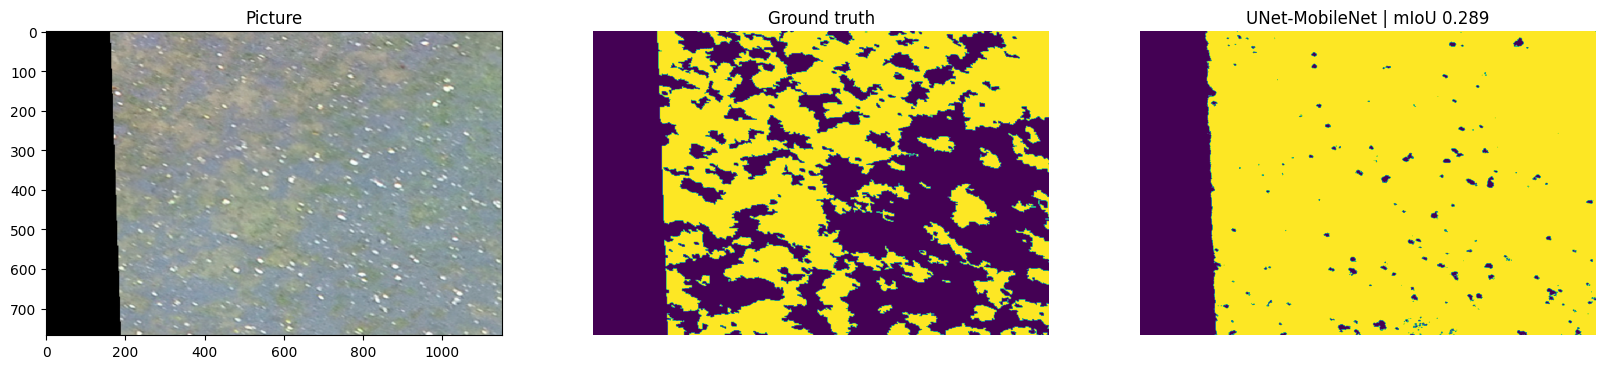

In [ ]:
image3, mask3 = test_set[33]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.5285802173164839


In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.3393681978632744
